In [ ]:
pip install 'git+https://github.com/ndeutschmann/zunis#egg=zunis&subdirectory=zunis_lib'

In [6]:
import torch
from torch.distributions import MultivariateNormal, Normal, MixtureSameFamily, Cauchy, Categorical
import numpy as np 

from models_.dot_dict import DotDict
from models_.infine import *
from models_.transformations import *
from models_.targets import * 
from models_.dump_results import *
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
#from zunis.integration import Integrator
import sys 
import gc

import os
from getpass import getpass
import urllib

%load_ext autoreload
%autoreload 2

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torchType = torch.float32

In [11]:
dim = 30

means = torch.tensor([[i,j] for i in range(-2,3) for j in range(-2,3)], dtype = torchType)

gaussians25 = torch.cat([means, torch.zeros(25,dim - 2)], -1)

var_mix = torch.tensor([0.01, 0.01] + [0.1]*(dim-2))

covs = torch.eye(dim).unsqueeze(0).repeat(25,1,1) * var_mix

mvn = MultivariateNormal(gaussians25.to(device), covs.to(device))

cat = Categorical((torch.tensor([1/25]*25)).to(device))

mixture = MixtureSameFamily(cat, mvn)

In [ ]:
K = 20

target = mixture

hamilt = DotDict()

var_p = 7

hamilt.dim = dim
hamilt.gamma = torch.tensor(2.5)
hamilt.dt = torch.tensor(0.1)
hamilt.K  = K
hamilt.var_Tp = 1
hamilt.clamp  = None

args_est = DotDict()

n_samples = 50000

args_est.K = K
args_est.device = device
args_est.dim = dim
args_est.distrib = mixture
args_est.target = lambda z : target.log_prob(z) + torch.tensor(10.).log()
args_est.a_k = torch.ones(args_est.K)
args_est.var_p = var_p
args_est.n_samples = n_samples
args_est.hamiltonian = hamilt
args_est.importance_distr = MultivariateNormal(torch.zeros(dim).to(device), 5*torch.eye(dim).to(device))

def f(x):

    y = math.pi * (x - (1/2))
    tan = y.tan()

    return 10.*(math.pi)**dim * target.log_prob(tan).exp().unsqueeze(-1) * torch.prod((1 + tan**2), -1, keepdim = True)

n_runs = 1

res_infine = []
vanilla_IS = []
neural_IS  = []

for run in range(n_runs):
    print(f'-----run: {run}/{n_runs}')
    torch.cuda.empty_cache()

    estimator = infine(args_est)
    estimator.to(device)

    %time infine_, *rem = estimator.estimate(verbose = False)
    print(f"\n----infine\n: {infine_}")
    
    res_infine.append(infine_.item())

    %time vanil_IS = estimator.classic_IS(n_samples = n_samples * K)
    vanilla_IS.append(vanil_IS.item())
    print(f"\n----vanilla IS\n: {vanil_IS}")
    #del estimator

    integrator = Integrator(d=dim,f=f,n_points = 20000, n_iter = 1,device=device, verbosity = 10, flow = 'pwlinear')
    %time result,*rem = integrator.integrate()

    print(f"\n----neural IS\n: {result}")
    neural_IS.append(result)

    memory = torch.cuda.memory_allocated()

-----run: 0/1


/home/achille/Documents/GitCodes/Non_equilibrium_VAE/NEO_code/models_/transformations.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_t = torch.exp(torch.tensor(-self.gamma*self.dt)) * p_t


CPU times: user 1min 11s, sys: 19.1 s, total: 1min 30s
Wall time: 22.2 s

----infine
: 8.084031105041504


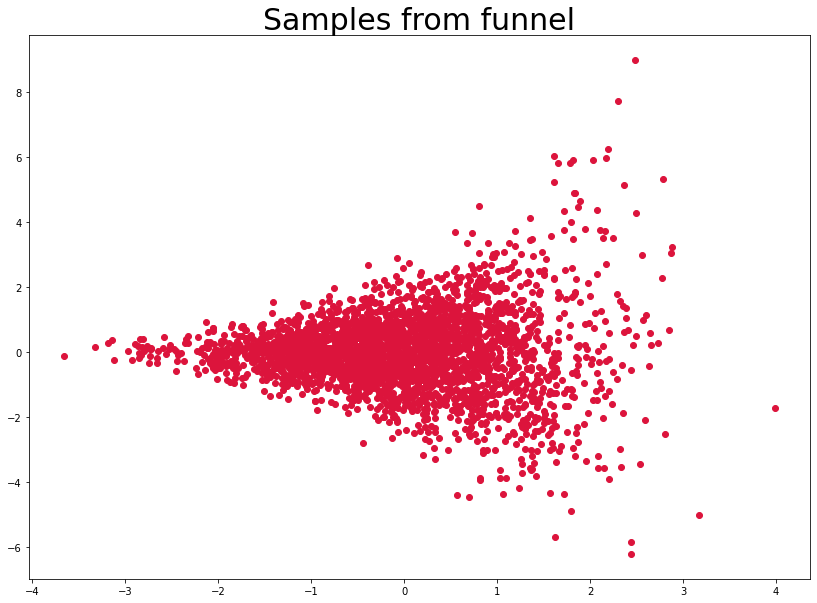

In [11]:
dim = 30

funnel_args = DotDict()
funnel_args.dim = dim 
funnel_args.device = device

target = Funnel(funnel_args)

plt.figure(figsize = (14,10))

funnel_samples = target.sample((3000,)).cpu()

plt.scatter(funnel_samples[:,0], funnel_samples[:,1], color = 'crimson')
plt.title('Samples from funnel', fontsize = 30)

def f(x):

    y = math.pi * (x - (1/2))
    tan = y.tan()

    return 10.*(math.pi)**dim * target.log_prob(tan).exp().unsqueeze(-1) * torch.prod((1 + tan**2), -1, keepdim = True)

In [ ]:
K = 10

hamilt = DotDict()

var_p = torch.tensor(1.).to(device)

hamilt.dim = dim
hamilt.gamma = torch.tensor(0.2).to(device)
hamilt.dt = torch.tensor(0.3).to(device)
hamilt.K  = K
hamilt.var_Tp = var_p
hamilt.clamp  = 10

args_est = DotDict()

args_est.K = K
args_est.device = device
args_est.dim = dim
args_est.distrib = target
args_est.target = lambda z : target.log_prob(z) + torch.tensor(10.).log()
args_est.a_k = torch.ones(args_est.K)
args_est.var_p = var_p
args_est.n_samples = 50000
args_est.hamiltonian = hamilt
args_est.importance_distr = MultivariateNormal(torch.zeros(dim).to(device), 5*torch.eye(dim).to(device))

n_runs = 10

res_infine = []
vanilla_IS = []
neural_IS  = []

for run in tqdm(range(n_runs)):

    torch.cuda.empty_cache()

    estimator = infine(args_est)
    estimator.to(device)

    %time infine_, *rem = estimator.estimate(verbose = False)
    print(f"\n-----infine result: {infine_}")
    
    res_infine.append(infine_.item())

    %time vanil_IS = estimator.classic_IS(n_samples = 50000 * K)
    vanilla_IS.append(vanil_IS.item())
    print(f"\n-----vanilla IS: {vanil_IS}")

    #del estimator
    try:
        integrator = Integrator(d=dim,f=f,n_points = 20000, n_iter = 1,device=device, verbosity = 10, flow = 'pwlinear')
        %time result,*rem = integrator.integrate()
        neural_IS.append(result)
        print(f"\n-----neural IS: {result}")
        
    except: 
        continue

In [13]:
dim = 15

args_cauchy = DotDict()
args_cauchy.loc = torch.tensor(0.).to(device)
args_cauchy.scale = torch.tensor(15.).to(device)
args_cauchy.dim = dim
args_cauchy.device = device 

cauchy_ = Cauchy_(args_cauchy)

args_cauchy_mixt = DotDict()
args_cauchy_mixt.loc = torch.tensor(5.).to(device)
args_cauchy_mixt.scale = torch.tensor(1.).to(device)
args_cauchy_mixt.dim = dim 
args_cauchy_mixt.device = device

mixt_cauchy = Cauchy_mixture(args_cauchy_mixt)

def f(x):

    y = math.pi * (x - (1/2))
    tan = y.tan()

    return 10.*(math.pi)**dim * target.log_prob(tan).exp().unsqueeze(-1) * torch.prod((1 + tan**2), -1, keepdim = True)

In [15]:
dim = dim

K = 30

target = mixt_cauchy

hamilt = DotDict()

var_p = 1

hamilt.dim = dim
hamilt.gamma = torch.tensor(.05).to(device)
hamilt.dt = torch.tensor(0.5).to(device)
hamilt.K  = K
hamilt.var_Tp = 0.5
hamilt.clamp  = None

args_est = DotDict()

n_samples = 70000

args_est.K = K
args_est.device = device
args_est.dim = dim
args_est.distrib = mixt_cauchy
args_est.target = lambda z : target.log_prob(z) + torch.tensor(10.).log()
args_est.a_k = torch.ones(args_est.K)
args_est.var_p = var_p
args_est.n_samples = n_samples
args_est.hamiltonian = hamilt
args_est.importance_distr = cauchy_

n_runs = 1

res_infine = []
vanilla_IS = []
neural_IS  = []

for run in range(n_runs):
    print(f'-----run: {run}/{n_runs}')
    torch.cuda.empty_cache()

    estimator = infine(args_est)
    estimator.to(device)

    %time infine_, *rem = estimator.estimate(verbose = False)
    print(f"\n----infine\n: {infine_}")
    res_infine.append(infine_.item())

    %time vanil_IS = estimator.classic_IS(n_samples = n_samples * (K//2))
    vanilla_IS.append(vanil_IS.item())
    print(f"\n----vanilla IS\n: {vanil_IS}")
    #del estimator

    integrator = Integrator(d=dim,f=f,n_points = 20000, n_iter = 1,device=device, verbosity = 10, flow = 'pwlinear')
    %time result,*rem = integrator.integrate()

    print(f"\n----neural IS\n: {result}")
    neural_IS.append(result)

-----run: 0/1
CPU times: user 21.8 s, sys: 7.21 s, total: 29.1 s
Wall time: 7.01 s

----infine
: 6.18065881729126
CPU times: user 2.39 s, sys: 467 ms, total: 2.86 s
Wall time: 928 ms

----vanilla IS
: 4.44943380355835


KeyboardInterrupt: 

NameError: name 'result' is not defined